# Quantum Fourier Transform on Superconducting Qubits (IBM Qiskit)

## Brief Description
This notebook implements the Quantum Fourier Transform (QFT) algorithm on a superconducting qubit architecture using IBM's **Qiskit** framework. The implementation follows the standard definition provided in Nielsen and Chuang's textbook.

We will proceed step by step:
1. **Define** the Quantum Fourier Transform.
2. **Set up** the IBM Qiskit environment.
3. **Build** the QFT helper functions (Hadamard and Controlled-Phase rotations).
4. **Set up** the full QFT circuit.
5. **Illustrate** the circuit diagram.
6. **Execute** the simulation and plot the measurement results.

## 1. QFT Definition
The Quantum Fourier Transform is a linear transformation on quantum qubits, and is the quantum analogue of the discrete Fourier transform.

The mathematical definition is:
$$
QFT|x\rangle = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i xy / N} |y\rangle
$$
where $N = 2^n$ is the dimension of the Hilbert space for $n$ qubits.

## 2. Setting up IBM Qiskit Platform

In [1]:
import numpy as np
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram

## 3. Build valid QFT rotation functions

In [2]:
def qft_rotations(circuit, n):
    """
    Qiskit implementation of QFT rotations (Hadamard + Controlled Phase).
    """
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """
    QFT requires swapping qubits at the end to match standard binary ordering.
    """
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

## 4. Set up QFT circuit gate

In [3]:
def qft_super_conducting(n: int, config: list[int], shots=1024, noise=False) -> dict:
    """
    Implements QFT on a Superconducting Quantum Computer Simulator (IBM Qiskit).
    Returns a sorted dictionary with all possible states included.
    """
    
    # 1. Initialize Quantum Circuit
    qc = QuantumCircuit(n)

    # 2. State Preparation
    for i in range(n):
        if config[i] == 1:
            qc.x(i)

    # 3. Apply QFT
    qft_rotations(qc, n)
    swap_registers(qc, n)

    # 4. Measurement
    qc.measure_all()

    # 5. Select Simulator (Ideal vs Noisy)
    if noise:
        backend = AerSimulator.from_backend(FakeManilaV2())
    else:
        backend = AerSimulator()

    # 6. Execution
    transpiled_qc = transpile(qc, backend)
    result = backend.run(transpiled_qc, shots=shots).result()
    raw_counts = result.get_counts()
    
    full_counts = {format(i, f'0{n}b'): 0 for i in range(2**n)}
    
    for bitstring, count in raw_counts.items():
        if bitstring in full_counts:
            full_counts[bitstring] = count
        
    sorted_counts = dict(sorted(full_counts.items()))
    
    return sorted_counts

# Initialize parameters
n = 5
config = [random.randint(0, 1) for _ in range(n)]
shots = 1024


## 5. Illustration graph of the circuit

Configuration: [0, 0, 1, 0, 0]
Ideal Result: {'00000': 35, '00001': 21, '00010': 33, '00011': 41, '00100': 34, '00101': 20, '00110': 29, '00111': 26, '01000': 26, '01001': 36, '01010': 23, '01011': 39, '01100': 32, '01101': 37, '01110': 28, '01111': 37, '10000': 26, '10001': 30, '10010': 34, '10011': 43, '10100': 35, '10101': 26, '10110': 36, '10111': 46, '11000': 39, '11001': 23, '11010': 28, '11011': 24, '11100': 34, '11101': 31, '11110': 23, '11111': 49}
Noisy Result: {'00000': 39, '00001': 36, '00010': 34, '00011': 34, '00100': 23, '00101': 26, '00110': 37, '00111': 41, '01000': 33, '01001': 31, '01010': 31, '01011': 28, '01100': 32, '01101': 42, '01110': 31, '01111': 31, '10000': 44, '10001': 37, '10010': 33, '10011': 25, '10100': 26, '10101': 30, '10110': 32, '10111': 30, '11000': 25, '11001': 36, '11010': 25, '11011': 35, '11100': 26, '11101': 29, '11110': 33, '11111': 29}


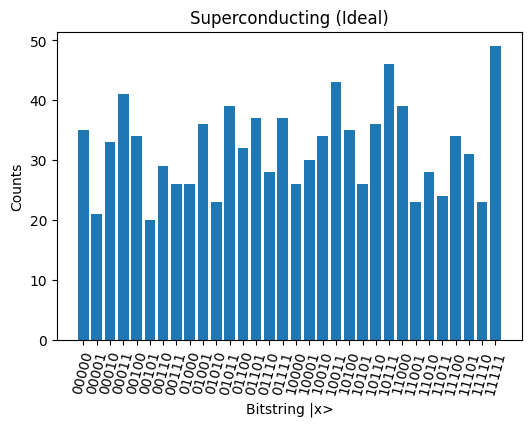

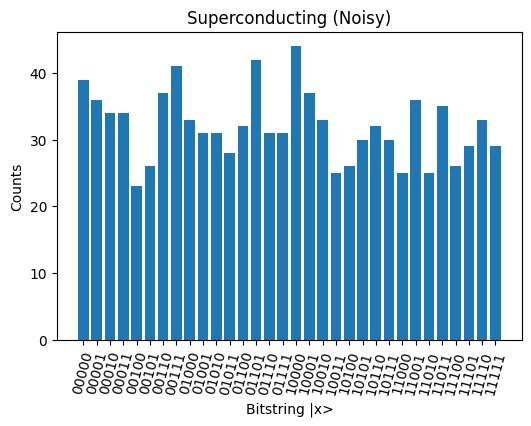

In [6]:
print(f"Configuration: {config}")

# Without noise
result_ideal = qft_super_conducting(n, config, shots, noise=False)
# With noise
result_noisy = qft_super_conducting(n, config, shots, noise=True)

print("Ideal Result:", result_ideal)
print("Noisy Result:", result_noisy)

def printHistogramCounts(dataset: map, title: str):
    
    # Extract x and y
    labels = list(dataset.keys())   
    values = list(dataset.values()) 

    # Plot
    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.xlabel("Bitstring |x>")
    plt.ylabel("Counts")
    plt.title(title)
    plt.xticks(rotation=75)  # rotate if needed
    plt.show()

printHistogramCounts(result_ideal, "Superconducting (Ideal)")
printHistogramCounts(result_noisy, "Superconducting (Noisy)")

## 6. Comparison

=== Performance Comparison ===


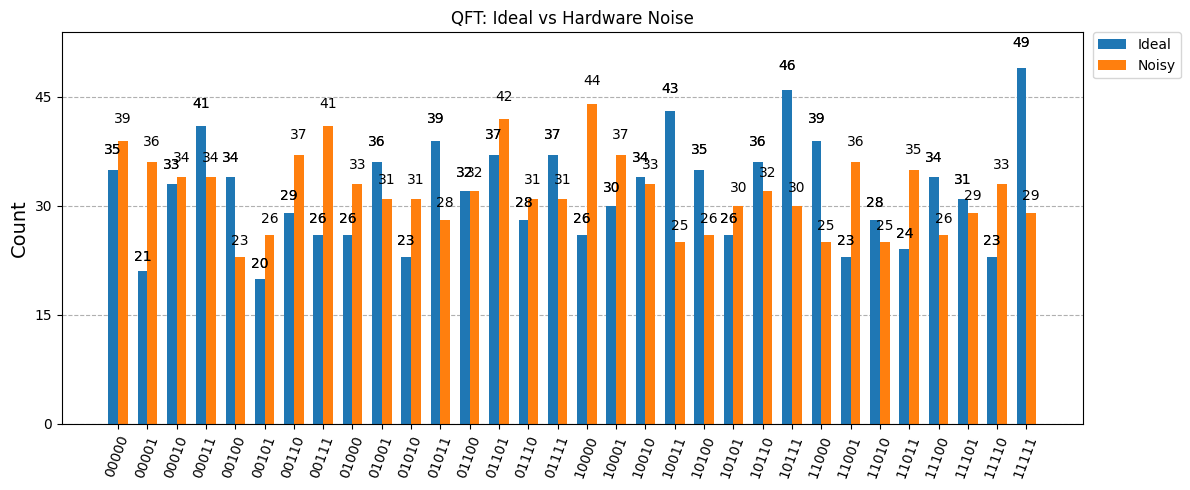

In [ ]:
plot_histogram([result_ideal, result_noisy], 
               legend=['Ideal', 'Noisy'], 
               title="QFT: Ideal vs Hardware Noise",
               figsize=(12, 5))

### 7. References
- Nielsen, Michael A., and Isaac L. Chuang. "Quantum Computation and Quantum Information: 10th Anniversary Edition." Cambridge University Press, 2010.
- Qiskit Community Team, "Quantum Fourier Transform," Qiskit Textbook.